In [203]:
import json
import pandas

In [340]:
target_index = 7

paper_data_path = "./slideMeta/slideData/" + str(target_index) + "/paperData.txt"
section_data_path = "./slideMeta/slideData/" + str(target_index) + "/sectionData.txt"
script_data_path = "./slideMeta/slideData/" + str(target_index) + "/scriptData.txt"

In [341]:
paperDataFile = open(paper_data_path, "r")
cnt = 0

paperBody = []

while True:
    line = paperDataFile.readline()
    
    if not line: 
        break
        
    raw = line.strip()
    paperBody.append(raw)
    # print(raw)
    # print('')
    
sectionDataFile = open(section_data_path, "r")
cnt = 0

sectionData = []

while True:
    line = sectionDataFile.readline()
    
    if not line: 
        break
        
    raw = line.strip()
    sectionData.append(raw)
    # print(raw)
    # print('')
    
# print(paperBody)
# print(sectionData)

print(len(paperBody))
print(len(sectionData))

115
115


In [342]:
import re
from string import digits
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer

# kjnltk.download()

def preprocess(t) :
    t=re.sub("\[.*?\]","",t)
    
    sentences = nltk.tokenize.sent_tokenize(t)
    
    # sentences = [ ' '.join(re.sub(r'[^\w]', ' ', s).split()) for s in sentences ]
    
    return sentences
    
def isAllowedSection(t) :
    if t == "REFERENCES" :
        return False
    else :
        return True

every_sentences = []
every_labels = []

def fixSectionTitles(section_titles):
    ret_titles = []
    title_num = 0
    last_section = None
    def is_main_section(title):
        if title[0] in digits or title.isupper() is True:
            return True
        return False
    for title in section_titles:
        if is_main_section(title) or last_section is None:
            ret_titles.append(title)
            last_section = title
        else:
            ret_titles.append(last_section)
    return ret_titles

for i in range(len(paperBody)) :
    sectionTitle = sectionData[i]
    p = paperBody[i]
    
    if not isAllowedSection(sectionTitle) :
        continue
            
    bodyText = preprocess(p)
            
    print(bodyText)
    
    every_labels = [*every_labels, *[sectionTitle for i in range(len(bodyText)) ] ]
    every_sentences = [*every_sentences, *bodyText]
            
every_labels = fixSectionTitles(every_labels)

__every_labels = []
__every_sentences = []

for i in range(len(every_labels)) :
    if every_labels[i].split(' ')[0].isdigit() :
        __every_labels.append(every_labels[i])
        __every_sentences.append(every_sentences[i])
        
every_labels = __every_labels
every_sentences = __every_sentences

['• Human-centered computing → Interaction design process and methods.']
['Distributed Energy, Blockchain, Theatre, Improvisation, Speculative Design, Critical Design, Deliberation']
['Larissa Pschetz, Kruakae Pothong, andChris Speed.', '2019.', 'Autonomous Distributed Energy Systems: Problematising the Invisible through Design, Drama and Deliberation.', 'In CHI Conference on Human']
['Paper 387 Page 1']
['Factors in Computing Systems Proceedings (CHI 2019), May 4–9, 2019, Glasgow, Scotland UK.', 'ACM, New York, NY, USA, 14 pages.', 'https://doi.org/10.1145/3290605.3300617']
['Energy provision inmost countries is traditionally centralised and heavily regulated.', 'Facilitated by progressive technology innovations, however, new models for energy provision are emerging with the potential to disrupt the existing supply model and alter relationships of trade.', 'New distributed energy systems are facilitated by emerging technologies that are able to collect, process and profile information

In [343]:
vectorizer = TfidfVectorizer(ngram_range=(1, 3))
X = vectorizer.fit_transform(every_sentences)

print(vectorizer.get_feature_names_out())

print(X.shape)

['10' '10 blockchain' '10 blockchain hpe' ... 'âăş' 'âăş reflecting'
 'âăş reflecting on']
(423, 15482)


In [344]:
import numpy as np

label_dict = sorted(list(set(every_labels)))
label_categories = [ label_dict.index(s) for s in every_labels ]

Y = np.array(*[label_categories])

Y.shape

(423,)

In [345]:
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
# define dataset
model = RandomForestClassifier()

model.fit(X, Y)

# from sklearn.datasets import load_iris
# from sklearn.linear_model import LogisticRegression

# model = LogisticRegression()

# model.fit(X, Y)

RandomForestClassifier()

In [346]:
def top_k_predictions(t, k):
    pre = ' '.join(preprocess(t))
    X2 = vectorizer.transform([pre])
    all_probs = model.predict_proba(X2)[0]
    args = argsort(all_probs)[-k:][::-1]
    ret = {}
    
    for arg in args:
        ret[label_dict[arg]] = all_probs[arg]
        
    return ret

def makePrediction(t) :
    pre = ' '.join(preprocess(t))
    
    X2 = vectorizer.transform([pre])
    
    return [ label_dict[s] for s in model.predict(X2) ]

def makePredictionProbability(t) :
    pre = ' '.join(preprocess(t))
    
    X2 = vectorizer.transform([pre])
    
    return model.predict_proba(X2)[0]
    
p = "how people use career mentoring relevant to their careers, and we will be focusing on the online communities as a source of mentoring. And the main research question we're asking is how people seek and receive advice."

result = makePredictionProbability(p)

print(result)
    

[0.02 0.09 0.41 0.32 0.12 0.01 0.03]


In [347]:
scriptDataFile = open(script_data_path, "r")
cnt = 0

scriptList = []

while True:
    line = scriptDataFile.readline()
    
    if not line: 
        break
        
    raw = line.strip()
    scriptList.append(raw)
    # print(raw)
    # print('')

__cnt = 0

probTable = []

# print(scriptList)

for i in range(len(scriptList)) :
    tokens = nltk.tokenize.word_tokenize(scriptList[i])
    
    sent = ''
    
    if len(tokens) < 25 :
        sent = '.'.join(scriptList[max(-2+i, 0):min(i+1, len(scriptList))])
    else :
        sent = scriptList[i]
        
    # print(i, ':', makePrediction(scriptList[i]))
    print(i, ':', makePrediction(sent))
    
    probTable.append(makePredictionProbability(sent))
    # print(scriptList[i])
    # print('')
    


0 : ['3 PROBLEMATISING THE INVISIBLE']
1 : ['3 PROBLEMATISING THE INVISIBLE']
2 : ['4 FUSING DESIGN, DRAMA AND DELIBERATION']
3 : ['3 PROBLEMATISING THE INVISIBLE']
4 : ['4 FUSING DESIGN, DRAMA AND DELIBERATION']
5 : ['3 PROBLEMATISING THE INVISIBLE']
6 : ['4 FUSING DESIGN, DRAMA AND DELIBERATION']
7 : ['3 PROBLEMATISING THE INVISIBLE']
8 : ['2 BACKGROUND Autonomous distributed energy systems']
9 : ['3 PROBLEMATISING THE INVISIBLE']
10 : ['3 PROBLEMATISING THE INVISIBLE']
11 : ['4 FUSING DESIGN, DRAMA AND DELIBERATION']
12 : ['3 PROBLEMATISING THE INVISIBLE']
13 : ['3 PROBLEMATISING THE INVISIBLE']
14 : ['3 PROBLEMATISING THE INVISIBLE']
15 : ['4 FUSING DESIGN, DRAMA AND DELIBERATION']
16 : ['3 PROBLEMATISING THE INVISIBLE']
17 : ['3 PROBLEMATISING THE INVISIBLE']
18 : ['3 PROBLEMATISING THE INVISIBLE']
19 : ['4 FUSING DESIGN, DRAMA AND DELIBERATION']
20 : ['4 FUSING DESIGN, DRAMA AND DELIBERATION']
21 : ['3 PROBLEMATISING THE INVISIBLE']
22 : ['3 PROBLEMATISING THE INVISIBLE']
23 : ['

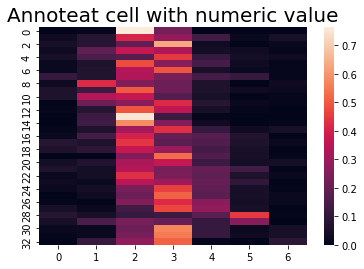

(0, '1 INTRODUCTION')
(1, '2 BACKGROUND Autonomous distributed energy systems')
(2, '3 PROBLEMATISING THE INVISIBLE')
(3, '4 FUSING DESIGN, DRAMA AND DELIBERATION')
(4, '5 DISCUSSION Design, drama and deliberation: enabling meaningful public engagement')
(5, '6 CONCLUSION')
(6, '7 ACKNOWLEDGMENTS')


In [348]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

sns.heatmap(probTable)

__probTable = probTable

for i in range(46, len(probTable)) :
    print(' '.join(map(str, probTable[i])))
    
plt.title('Annoteat cell with numeric value', fontsize=20)
plt.show()


for e in enumerate(label_dict) :
    print(e)

In [ ]:
def fixSectionTitles(section_titles):
    ret_titles = []
    title_num = 0
    last_section = None
    def is_main_section(title):
        if title[0] in digits or title.isupper() is True:
            return True
        return False
    for title in section_titles:
        if is_main_section(title) or last_section is None:
            ret_titles.append(title)
            last_section = title
        else:
            ret_titles.append(last_section)
    print(ret_titles)
    return ret_titles
